# DATA cleaner
Cleans seeds from DATA

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from C4.connect4_env import Connect4Env

In [2]:
# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def player_from_ply(ply: int) -> int:
    """Env starts with +1 and alternates; ply is 1-based."""
    return 1 if (ply % 2 == 1) else -1


def infer_winner_for_group(g: pd.DataFrame) -> int:
    """
    Infer game winner from final reward + ply parity.

    Returns:
        +1  -> player +1 won
        -1  -> player -1 won
         0  -> draw / unknown
    """
    g = g.sort_values("ply")
    last = g.iloc[-1]
    last_ply = int(last["ply"])
    rT = float(last["reward"])
    last_player = player_from_ply(last_ply)

    if rT >= 0.5 * WIN_R:           return last_player
    elif rT <= 0.5 * LOSS_R:        return -last_player
    elif abs(rT - DRAW_R) < 1e-6:   return 0
    else:                           return 0


def clean_one_dataframe(df: pd.DataFrame, src_name: str) -> pd.DataFrame:
    """
    From raw per-move dataframe (label, reward, game, ply, board cells),
    return only rows of "good" moves:

      - only moves from the eventual winner
      - optionally drop moves with reward <= BAD_REWARD_THRESHOLD

    Adds:
      - 'player' (who moved)
      - 'winner' (who won the game)
      - 'src' (origin file)
    """
    kept_rows = []

    if "src" not in df.columns:
        df = df.copy()
        df["src"] = src_name

    groups = df.groupby(["label", "game"])
    for (label, game_id), g in tqdm(
        groups,
        total=len(groups),
        desc=f"Games in {src_name}",
        leave=True,
    ):
        g = g.sort_values("ply")

        if len(g) < MIN_PLY or len(g) > MAX_PLY:
            continue

        winner = infer_winner_for_group(g)
        if winner == 0 and DROP_DRAWS:
            continue

        ply_arr = g["ply"].to_numpy()
        players = np.where((ply_arr % 2) == 1, 1, -1)
        g = g.assign(player=players, winner=int(winner))

        if winner != 0:
            g_win = g[g["player"] == winner].copy()
        else:
            g_win = g.copy()

        if g_win.empty: continue

        # drop "obviously bad" moves by the eventual winner
        g_win = g_win[g_win["reward"] > BAD_REWARD_THRESHOLD]
        if g_win.empty: continue

        kept_rows.append(g_win)

    if not kept_rows:
        return pd.DataFrame(columns=df.columns)

    out = pd.concat(kept_rows, ignore_index=True)
    return out

In [3]:
# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
DATA_FILES = [
    "DATA/C4.play_data.xlsx",
    "DATA/C4.Lossy_play_data.xlsx",
]

OUT_FILE = "DATA/C4.play_data_BC_clean.xlsx"

# Game-level filters
MIN_PLY = 6          # drop ultra-short games (trivial)
MAX_PLY = 42         # sanity cap (all normal C4 games fit)

DROP_DRAWS = True    # don't use drawn games as "expert"

# Move-level filters (for the *winner's* moves)
env_tmp = Connect4Env()
WIN_R  = float(env_tmp.WIN_REWARD)
LOSS_R = float(env_tmp.LOSS_PENALTY)
DRAW_R = float(env_tmp.DRAW_REWARD)

BAD_REWARD_THRESHOLD = -40.0   # shaped reward <= this is considered bad and dropped


# ------------------------------------------------------------------
# Main cleaning pipeline with progress bars
# ------------------------------------------------------------------
all_clean = []

for path in tqdm(DATA_FILES, desc="Files", leave=True):
    path = Path(path)
    print(f"\nLoading {path} ...")
    df_raw = pd.read_excel(path)

    df_clean = clean_one_dataframe(df_raw, src_name=path.name)
    print(f"  kept {len(df_clean)} rows from {path.name}")
    all_clean.append(df_clean)

if all_clean:
    df_all = pd.concat(all_clean, ignore_index=True)
else:
    df_all = pd.DataFrame()

if not df_all.empty:
    env = env_tmp

    board_cols = [f"{r}-{c}" for r in range(env.ROWS) for c in range(env.COLS)]
    front_cols = ["src", "label", "reward", "game", "ply", "player", "winner"]
    col_order = front_cols + board_cols

    # ensure all front_cols exist
    for col in front_cols:
        if col not in df_all.columns:
            df_all[col] = 0

    # ensure all board columns exist
    for col in board_cols:
        if col not in df_all.columns:
            df_all[col] = 0

    # reorder
    df_all = df_all[col_order]

    # ---------- UPSERT TO OUT_FILE ----------
    out_path = Path(OUT_FILE)
    if out_path.exists():
        try:
            existing = pd.read_excel(out_path)
            # make sure existing has all needed columns too
            for col in col_order:
                if col not in existing.columns:
                    existing[col] = 0
            existing = existing[col_order]

            combined = pd.concat([existing, df_all], ignore_index=True)
        except Exception:
            # if something is wrong with old file, just start fresh
            combined = df_all.copy()
    else:
        combined = df_all.copy()

    # drop exact duplicates across all columns
    combined = combined.drop_duplicates().reset_index(drop=True)

    # final safety: enforce column order
    combined = combined[col_order]

    combined.to_excel(out_path, index=False)
    print(f"\n✅ Saved {len(combined)} rows into {OUT_FILE}")
else:
    print("\n⚠ No rows survived cleaning. Check thresholds or source data.")



Files:   0%|          | 0/2 [00:00<?, ?it/s]


Loading DATA\C4.play_data.xlsx ...


Games in C4.play_data.xlsx:   0%|          | 0/305 [00:00<?, ?it/s]

  kept 3138 rows from C4.play_data.xlsx

Loading DATA\C4.Lossy_play_data.xlsx ...


Games in C4.Lossy_play_data.xlsx:   0%|          | 0/241 [00:00<?, ?it/s]

  kept 1945 rows from C4.Lossy_play_data.xlsx

✅ Saved 23649 rows into DATA/C4.play_data_BC_clean.xlsx


In [4]:
df_all[["reward"]].describe()

,reward
count,5083.000000
mean,134.160801
std,300.392210
min,-0.100000
25%,6.950000
50%,28.000000
75%,55.850000
max,1000.000000


In [5]:
combined[["reward"]].describe()

,reward
count,23649.000000
mean,133.944162
std,305.260744
min,-34.000000
25%,6.500000
50%,29.500000
75%,45.250000
max,1000.000000


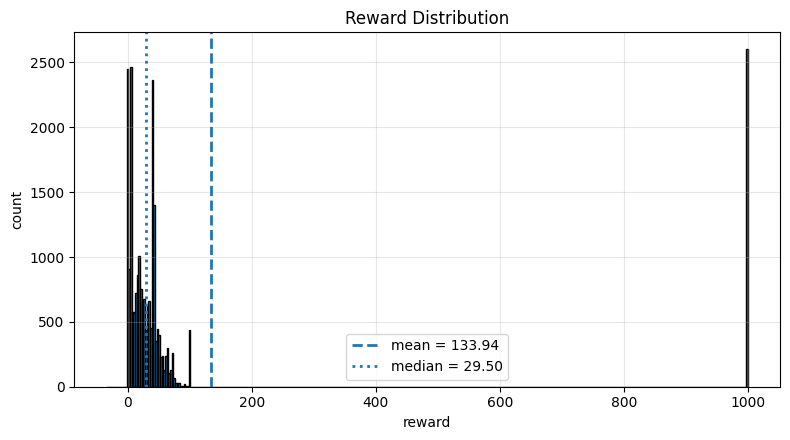

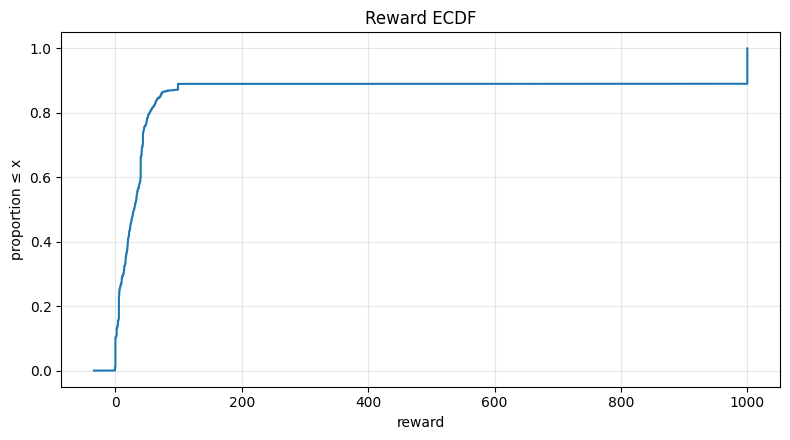

In [6]:
r = combined["reward"].astype(float).dropna()

# --- Histogram ---
fig, ax = plt.subplots(figsize=(8,4.5))
bins = np.arange(r.min()-0.5, r.max()+1.5, 1) if np.allclose(r, r.round()) else "auto"
n, bins, _ = ax.hist(r, bins=bins, edgecolor="black")
ax.axvline(r.mean(),   ls="--", lw=2, label=f"mean = {r.mean():.2f}")
ax.axvline(r.median(), ls=":",  lw=2, label=f"median = {r.median():.2f}")
ax.set(title="Reward Distribution", xlabel="reward", ylabel="count")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()

r_sorted = np.sort(r.values)
y = np.arange(1, len(r_sorted)+1) / len(r_sorted)
plt.figure(figsize=(8,4.5))
plt.plot(r_sorted, y)
plt.title("Reward ECDF")
plt.xlabel("reward")
plt.ylabel("proportion ≤ x")
plt.grid(True, alpha=0.3)
plt.tight_layout()